## Установка библиотек

In [2]:
!pip install livelossplot
!pip install gdown
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_vggface
!pip install keras_applications --no-deps

## Импорт библиотек

In [3]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from statistics import mode
import tensorflow_hub as hub
from PIL import ImageFilter, ImageEnhance
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot.tf_keras import PlotLossesCallback
from PIL import Image
import seaborn as sns
import time
from keras_vggface import utils
from tensorflow.keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print(tf.__version__)

2.4.1


## Загрузка датафреймов с данными

In [4]:
data_folder = Path('./Data')  # root directory with data

df = pd.read_csv(data_folder / 'df_cleared.csv')  # train dataset №1
df_cropped = pd.read_csv(data_folder / 'df_cropped_cleared.csv')  # train dataset №2 with cropped faces
df_test = pd.read_csv(data_folder / 'df_test.csv')  # test dataset

Создадим словарь для перевода эмоции в численную категорию и наоборот

In [5]:
emotion_mapping = dict(enumerate(df['emotion'].unique()))
emotion_mapping

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise',
 8: 'uncertain'}

Подготовим функции с фильтрами для аугментации изображений

In [6]:
def add_noise(noise_typ, img):

    """Adds noise on an image"""

    image = img / 255.
    if noise_typ == "gauss":
        row, col, ch = image.shape
        mean = 0
        var = 0.002
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        out = gauss + image
        out =  np.clip(out, 0, 1)
    elif noise_typ == "s&p":
        row, col, ch = image.shape
        s_vs_p = 0.5
        amount = 0.02
        out = np.copy(image)

        # "Salt"
        num_salt = np.ceil(amount * row * col * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape[:2]]
        out[tuple(coords)] = np.random.uniform(0.6, 1.0)

        # "Pepper"
        num_pepper = np.ceil(amount* row * col * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape[:2]]
        out[tuple(coords)] = np.random.uniform(0, 0.4)
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        out = np.clip(noisy, 0, 1)
    return (out * 255).astype(np.uint8)


def apply_filter(filter_type, img):

    """Applies blur or color filter"""

    image = Image.fromarray(img)
    if filter_type == 'blur':
        out = image.filter(filter=ImageFilter.BLUR)
    elif filter_type == 'color':
        enhancer = ImageEnhance.Color(image)
        out = enhancer.enhance(np.random.uniform(0.4, 1.3))
    elif filter_type == 'gblur':
        out = image.filter(ImageFilter.GaussianBlur(1))
    return np.array(out)


def random_transformation(image):

    """Transforms the image with a randomfilter or noise. 
    It accepts an array with the following dimensions as input
    (height, width, number of channels) and with a color value in the range [0, 255]. 
    It varies the color saturation and the addition of noise\blur with
    a probability of 60%"""

    transformations = [lambda x: add_noise('gauss', x),
                       lambda x: add_noise('s&p', x),
                       lambda x: add_noise('poisson', x),
                       lambda x: apply_filter('blur', x),
                       lambda x: apply_filter('gblur', x),
                       lambda x: x] # no filter
    p = [0.12, 0.12, 0.12, 0.12, 0.12, 0.40]
    trans_fn = np.random.choice(transformations, p=p)

    return apply_filter('color', trans_fn(image.astype(np.uint8))).astype(image.dtype)

## Функция для определения скорости инференса

In [7]:
def benchmark_model(model, sample, iterations=200):

    """Функция для тестирования времени инференса модели"""

    model(sample)  # "warm-up"
    inference_times = []

    for i in range(iterations):
        start = time.time()
        model(sample)
        inference_times.append(time.time() - start)

    mean_time = np.mean(inference_times)
    median_time = np.median(inference_times)

    plt.plot(inference_times)
    plt.title(f'Inference time over {iterations} iterations on one picture\n'
              f'mean time = {mean_time:.3f}sec, median time = {median_time:.3f}sec')
    plt.xlabel('Iteration number')
    plt.ylabel('Inference time, sec')
    plt.show()

    return mean_time, median_time

## Разделения датасетов на обучающую и валидационную выборки

In [8]:
def stratified_split_df(dataframe, validation_split=0.1, seed=42):

    """Divides the dataset into test and training samples keeping proportions between classes"""

    random_seed = np.random.RandomState(seed=seed)
    indices = []

    for category in dataframe['emotion'].unique():
        category_df = dataframe[dataframe['emotion'] == category]
        category_df_len = int(category_df.shape[0] * validation_split)
        category_indices = random_seed.choice(category_df.index, size=category_df_len, replace=False)
        indices.extend(list(category_indices))

    train_part = dataframe.drop(indices, axis=0)
    val_part = dataframe.loc[indices,:]

    return train_part, val_part

In [9]:
df_train, df_val = stratified_split_df(df)
print(f'Размер тренировочного датасета: {df_train.shape[0]}')
print(f'Размер валидационного датасета: {df_val.shape[0]}')

Размер тренировочного датасета: 44519
Размер валидационного датасета: 4942


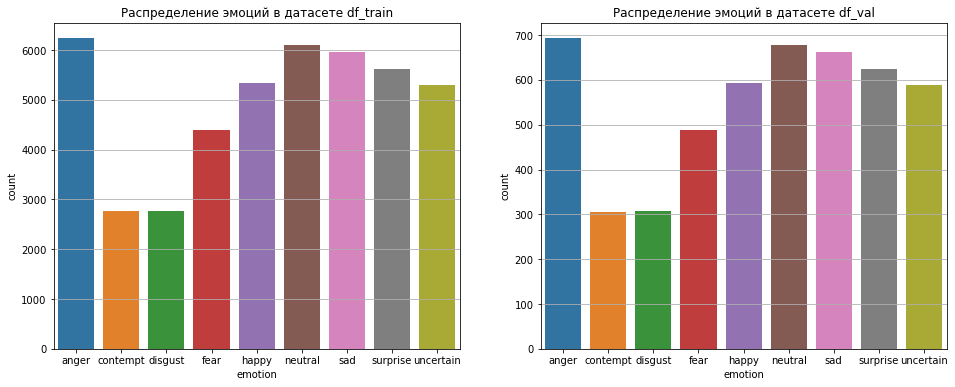

In [10]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.countplot(data = df_train, x='emotion').set_title('Распределение эмоций в датасете df_train')
plt.grid(axis='y')

plt.subplot(1, 2, 2)
sns.countplot(data = df_val, x='emotion').set_title('Распределение эмоций в датасете df_val')
plt.grid(axis='y')
plt.show()

In [11]:
df_train_cropped, df_val_cropped = stratified_split_df(df_cropped)
print(f'Размер тренировочного датасета c вырезанными лицами: {df_train_cropped.shape[0]}')
print(f'Размер валидационного датасета с вырезанными лицами: {df_val_cropped.shape[0]}')

Размер тренировочного датасета c вырезанными лицами: 44440
Размер валидационного датасета с вырезанными лицами: 4933


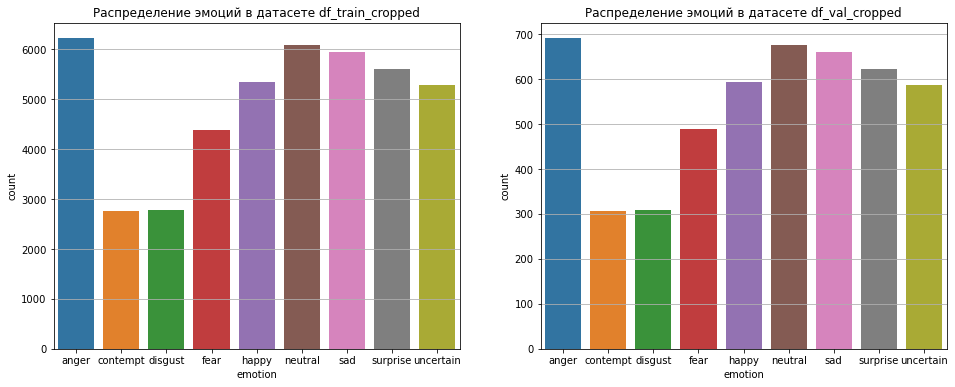

In [12]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.countplot(data = df_train_cropped, x='emotion').set_title('Распределение эмоций в датасете df_train_cropped')
plt.grid(axis='y')

plt.subplot(1, 2, 2)
sns.countplot(data = df_val_cropped, x='emotion').set_title('Распределение эмоций в датасете df_val_cropped')
plt.grid(axis='y')
plt.show()

Распределение данных по категориям в тренировочных и тестовых датасетах идентичное

## Генераторы данных и Callbacks

Подготовим функцию создающию генераторы данных для обучения моделей

In [13]:
def build_generators(dataset='normal', train=df_train, val=df_val, batch_size=224, image_size=16, preprocessing_function_train=None, preprocessing_function_val=None):

    """Creates generators for training and validation data with the specified parameters"""

    if dataset == 'normal':
        train_image_generator = ImageDataGenerator(rotation_range=15,
                                                   width_shift_range=.15,
                                                   height_shift_range=.15,
                                                   horizontal_flip=True,
                                                   fill_mode='nearest',
                                                   brightness_range=(0.6, 1.4),
                                                   shear_range=0.2,
                                                   preprocessing_function=preprocessing_function_train)

    elif dataset == 'cropped':
        train_image_generator = ImageDataGenerator(rotation_range=2,
                                                   width_shift_range=.05,
                                                   height_shift_range=.05,
                                                   horizontal_flip=True,
                                                   fill_mode='nearest',
                                                   brightness_range=(0.5,1.5),
                                                   shear_range=0.1,
                                                   zoom_range=.05,
                                                   preprocessing_function=preprocessing_function_train)

    else:
        raise ValueError("dataset should be equal 'normal' or 'cropped'")

    train_generator = train_image_generator.flow_from_dataframe(dataframe=train,
                                                                x_col='image_path',
                                                                y_col='emotion',
                                                                target_size=(image_size, image_size),
                                                                batch_size=batch_size,
                                                                class_mode='sparse',
                                                                directory=str(data_folder),
                                                                shuffle=True,
                                                                interpolation='nearest',
                                                                validate_filenames=True)

    val_image_generator = ImageDataGenerator(preprocessing_function=preprocessing_function_val)

    val_generator = val_image_generator.flow_from_dataframe(dataframe=val,
                                                            directory=str(data_folder),
                                                            x_col='image_path',
                                                            y_col='emotion',
                                                            target_size=(image_size, image_size),
                                                            batch_size=batch_size,
                                                            class_mode='sparse',
                                                            shuffle=False,
                                                            interpolation='nearest',
                                                            validate_filenames=True)

    return train_generator, val_generator

Функция для callbacks моделей

In [14]:
def build_callbacks(save_path:str):

    """Defines Callbacks and their parameters necessary for training models"""

    path = Path(save_path)
    path.mkdir(exist_ok=True)
    cpt_filename = "checkpoint_best.hdf5"
    cpt_path =str(path / cpt_filename)

    model_checkpoint = ModelCheckpoint(cpt_path,
                                       monitor='val_sparse_categorical_accuracy',
                                       verbose=1,
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode='max')

    model_lr_reducer = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy',
                                         patience=2,
                                         factor=0.2,
                                         mode='max')

    model_stopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0, patience=6, mode='auto')

    return model_checkpoint, model_lr_reducer, model_stopper

## VGGFace

Сеть VGG, была обучена на датасете [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) для классификации лиц. Она содержит 3.3 миллиона изображений с 9000 разными персоналиями. [Источник](https://github.com/rcmalli/keras-vggface)


### Датасет №1

In [15]:
vggface_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

In [16]:
vggface_model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [17]:
vggface_model = tf.keras.Sequential([vggface_model,
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(9, activation='softmax')])
vggface_model.build(input_shape=(None, 224, 224, 3))
vggface_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 18441     
Total params: 23,579,593
Trainable params: 23,526,473
Non-trainable params: 53,120
_________________________________________________________________


In [18]:
def preprocess_vgg_train(image_):
    
    """image_ - tensor of size (1, H, W, 3)
    return: image, with preprocess_input applied (..., version=2) from keras_vggface
    with the addition of augmentation using the random_transformation function"""
    
    image_ = random_transformation(image_)
    preprocessed_image = utils.preprocess_input(image_, version=2)

    return preprocessed_image

In [19]:
def preprocess_vgg_val(image_):
    
    """image_ - tensor of size (1, H, W, 3)
    return: image, with preprocess_input applied (..., version=2) from keras_vggface"""
    
    preprocessed_image = utils.preprocess_input(image_, version=2)

    return preprocessed_image

In [55]:
train_gen, val_gen = build_generators(dataset='normal',
                                      train=df_train,
                                      val=df_val,
                                      image_size=224,
                                      batch_size=16,
                                      preprocessing_function_train=preprocess_vgg_train,
                                      preprocessing_function_val=preprocess_vgg_val)

Found 44519 validated image filenames belonging to 9 classes.
Found 4942 validated image filenames belonging to 9 classes.


In [21]:
vggface_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                      loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'])

In [22]:
checkpoint, lr_reducer, early_stopper = build_callbacks(save_path="model_resnet50_trial")

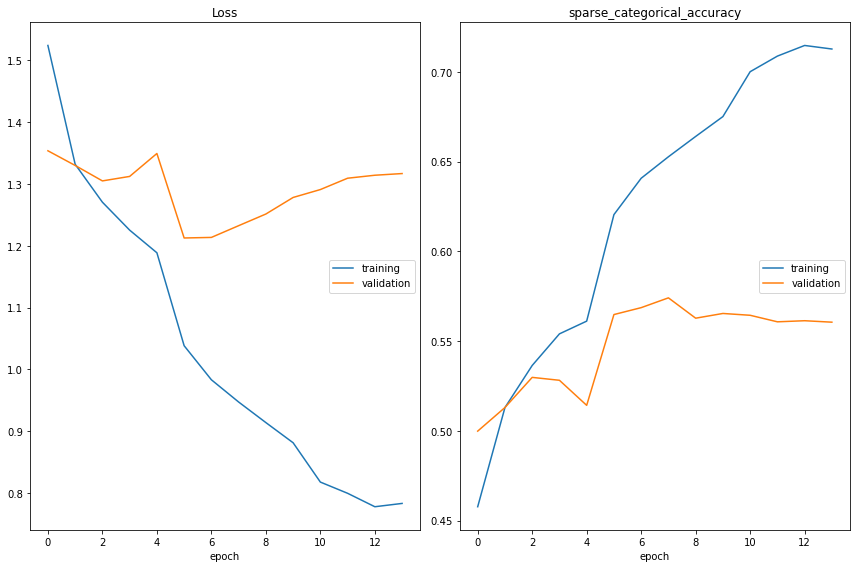

Loss
	training         	 (min:    0.778, max:    1.524, cur:    0.783)
	validation       	 (min:    1.213, max:    1.354, cur:    1.317)
sparse_categorical_accuracy
	training         	 (min:    0.458, max:    0.715, cur:    0.713)
	validation       	 (min:    0.500, max:    0.574, cur:    0.561)

Epoch 00014: val_sparse_categorical_accuracy did not improve from 0.57406


In [23]:
vggface_model.fit(train_gen,
                  epochs=20,
                  validation_data=val_gen,
                  callbacks=[PlotLossesCallback(), checkpoint, lr_reducer, early_stopper])

In [25]:
vggface_model.save('./saved_model_resnet50_trial/1')

In [23]:
vggface_model.load_weights("model_resnet50_trial/checkpoint_best.hdf5")
loss, acc = vggface_model.evaluate(val_gen)

309/309 [==============================] - 72s 159ms/step - loss: 1.2372 - sparse_categorical_accuracy: 0.5846


In [24]:
vggface_model = tf.keras.models.load_model('./saved_model_resnet50_trial/1')
vggface_model.evaluate(val_gen)

### Определение скорости инференса

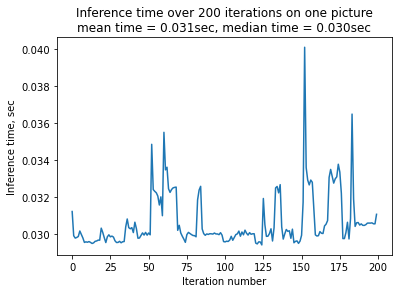

In [56]:
x, _ = next(train_gen)
sample = x[0:1]
benchmark_model(vggface_model, sample)

### Предикт на тестовых данных

С помощью датафрейма с тестовыми данными df_test сделаем предикт и подготовим итоговый датафрейм для загрузки его на Kaggle

In [65]:
def make_submission(model, preprocessing_function, preprocess=True):

    """The function for creating a dataframe with predictions based on test data"""

    submissions = []

    for file in tqdm(df_test.image_path):
        img = image.load_img(data_folder / 'test_kaggle' / file, target_size=(224, 224))
        x_i = image.img_to_array(img)
        x_i = np.expand_dims(x_i, axis=0)
        if preprocess:
            x_i = preprocessing_function(x_i)
        model_predicts = model.predict(x_i)
        emotions = emotion_mapping[np.argmax(model_predicts)]
        submissions.append((file, emotions))

    submission_df = pd.DataFrame()
    submission_df['image_path'], submission_df['emotion'] = zip(*submissions)

    return submission_df

In [66]:
sample_submission = make_submission(model=vggface_model,
                                    preprocessing_function=preprocess_vgg_val,
                                    preprocess=True)

100%|██████████| 5000/5000 [04:06<00:00, 20.30it/s]


Сделаем выгрузку в csv для Kaggle

In [67]:
sample_submission.to_csv(data_folder / 'sample_submission_resnet50.csv', index=False)

In [6]:
vgg_submission = pd.read_csv(data_folder / 'sample_submission_resnet50.csv')

Взглянем на получившиеся данные

In [69]:
sample_submission['image_path'] = sample_submission['image_path'].apply(lambda x: './test_kaggle/' + x)
sample_submission.head()

,image_path,emotion
0,./test_kaggle/0.jpg,sad
1,./test_kaggle/1.jpg,surprise
2,./test_kaggle/10.jpg,neutral
3,./test_kaggle/100.jpg,sad
4,./test_kaggle/1000.jpg,happy


In [70]:
def show_emotion_distribution(dataframe):
    fig, ax = plt.subplots(figsize = (10, 5))
    sns.countplot(data = dataframe, x='emotion', ax=ax).set_title('Распределение эмоций для тестовых данных')
    plt.grid(axis='y')
    plt.show()

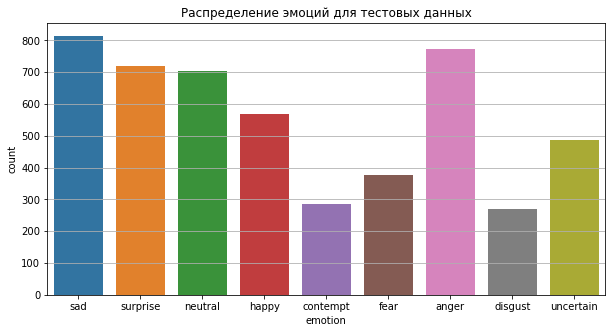

In [71]:
show_emotion_distribution(sample_submission)

### Score on Kaggle

Результаты:
- Private Score: 0.56480
- Public Score: 0.57199

![VGG.png](https://cloud.telecombg.ru/index.php/s/NpjS8YkeRHcTQap/preview)

### Датасет №2

In [45]:
vggface_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

vggface_model = tf.keras.Sequential([vggface_model,
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(9, activation='softmax')])

vggface_model.build(input_shape=(None, 224, 224, 3))

In [54]:
train_gen, val_gen = build_generators(dataset='cropped',
                                      train=df_train_cropped,
                                      val=df_val_cropped,
                                      image_size=224,
                                      batch_size=16,
                                      preprocessing_function_train=preprocess_vgg_train,
                                      preprocessing_function_val=preprocess_vgg_val)

Found 44440 validated image filenames belonging to 9 classes.
Found 4933 validated image filenames belonging to 9 classes.


In [47]:
vggface_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                      loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'])

In [48]:
checkpoint, lr_reducer, early_stopper = build_callbacks(save_path="model_resnet50_cropped")

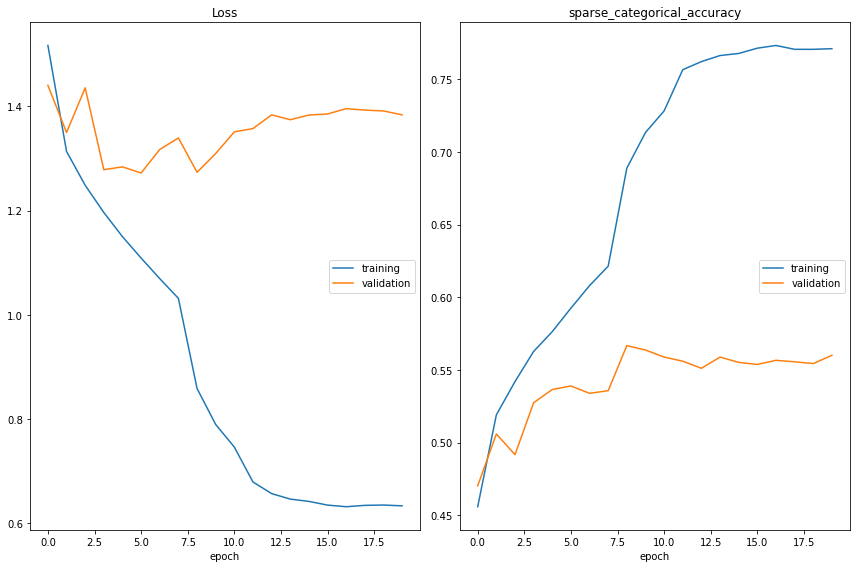

Loss
	training         	 (min:    0.632, max:    1.517, cur:    0.634)
	validation       	 (min:    1.272, max:    1.440, cur:    1.384)
sparse_categorical_accuracy
	training         	 (min:    0.456, max:    0.773, cur:    0.771)
	validation       	 (min:    0.470, max:    0.567, cur:    0.560)

Epoch 00020: val_sparse_categorical_accuracy did not improve from 0.56680


In [42]:
vggface_model.fit(train_gen,
                  epochs=20,
                  validation_data=val_gen,
                  callbacks=[PlotLossesCallback(), checkpoint, lr_reducer, early_stopper])

In [43]:
vggface_model.save('./saved_model_resnet50_cropped/1')

INFO:tensorflow:Assets written to: ./saved_model_resnet50_cropped/1/assets


In [ ]:
vggface_model.load_weights("model_resnet50_cropped/checkpoint_best.hdf5")
loss, acc = vggface_model.evaluate(val_gen)

In [49]:
vggface_model = tf.keras.models.load_model('./saved_model_resnet50_cropped/1')
vggface_model.evaluate(val_gen)

309/309 [==============================] - 36s 115ms/step - loss: 1.3971 - sparse_categorical_accuracy: 0.5514

### Определение скорости инференса

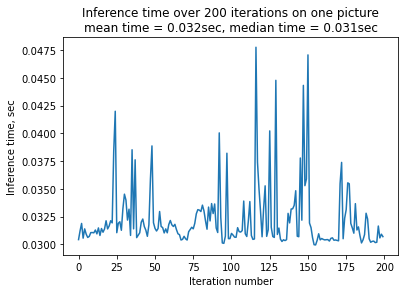

(0.03225914239883423, 0.03137063980102539)

In [50]:
x, _ = next(train_gen)
sample = x[0:1]
benchmark_model(vggface_model, sample)

### Предикт на тестовых данных

In [51]:
sample_submission = make_submission(model=vggface_model,
                                    preprocessing_function=preprocess_vgg_val,
                                    preprocess=True)

100%|██████████| 5000/5000 [04:10<00:00, 19.94it/s]


Сделаем выгрузку в csv для Kaggle

In [52]:
sample_submission.to_csv(data_folder / 'sample_submission_resnet50_cropped.csv', index=False)

In [53]:
sample_submission = pd.read_csv(data_folder / 'sample_submission_resnet50_cropped.csv')

Взглянем на получившиеся данные

In [54]:
sample_submission['image_path'] = sample_submission['image_path'].apply(lambda x: './test_kaggle/' + x)
sample_submission.head()

,image_path,emotion
0,./test_kaggle/0.jpg,sad
1,./test_kaggle/1.jpg,neutral
2,./test_kaggle/10.jpg,neutral
3,./test_kaggle/100.jpg,fear
4,./test_kaggle/1000.jpg,happy


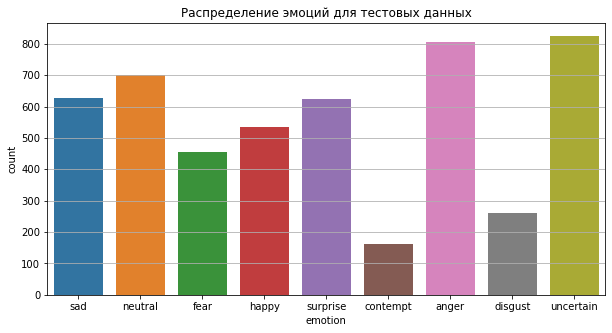

In [55]:
show_emotion_distribution(sample_submission)

### Score on Kaggle

Результаты:
- Private Score: 0.49440
- Public Score: 0.51640

![VGG-full-dataset.png](https://cloud.telecombg.ru/index.php/s/qkdnmRtnojPeBPL/preview)

## Xception

Обычный свёрточный слой одновременно обрабатывает как пространственную информацию (корреляцию соседних точек внутри одного канала), так и межканальную информацию, так как свёртка применяется ко всем каналам сразу. Архитектура Xception базируется на предположении о том, что эти два вида информации можно обрабатывать последовательно без потери качества работы сети, и раскладывает обычную свёртку на pointwise convolution (которая обрабатывает только межканальную корреляцию) и spatial convolution (которая обрабатывает только пространственную корреляцию в рамках отдельного канала).
На датасете ImageNet эта модель достигает топ-1 точности на валидации 0,790 и топ-5 точности на валидации 0,945.[Статья](https://arxiv.org/abs/1610.02357)

### Датасет №1

In [28]:
xception_model = tf.keras.applications.xception.Xception(include_top=False,
                                                         weights='imagenet',
                                                         input_tensor=None,
                                                         input_shape=(224, 224, 3),
                                                         pooling='max',
                                                         classes=9,
                                                         classifier_activation='softmax')

In [29]:
xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [30]:
xception_model = tf.keras.Sequential([xception_model, tf.keras.layers.Dense(9, activation='softmax')])
xception_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 18441     
Total params: 20,879,921
Trainable params: 20,825,393
Non-trainable params: 54,528
_________________________________________________________________


In [31]:
def preprocessing_xception_train(img_):

    """Library preprocessing for the xception model
       with the addition of random transformation"""

    img_ = random_transformation(img_)
    img_ = tf.keras.applications.xception.preprocess_input(img_)
    return img_

In [57]:
train_gen, val_gen = build_generators(dataset='normal',
                                      train=df_train,
                                      val=df_val,
                                      image_size=224,
                                      batch_size=16,
                                      preprocessing_function_train=preprocessing_xception_train,
                                      preprocessing_function_val=tf.keras.applications.xception.preprocess_input)

Found 44519 validated image filenames belonging to 9 classes.
Found 4942 validated image filenames belonging to 9 classes.


In [33]:
xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                       loss='sparse_categorical_crossentropy',
                       metrics=['sparse_categorical_accuracy'])

In [34]:
checkpoint, lr_reducer, early_stopper = build_callbacks(save_path="model_xception_trial")

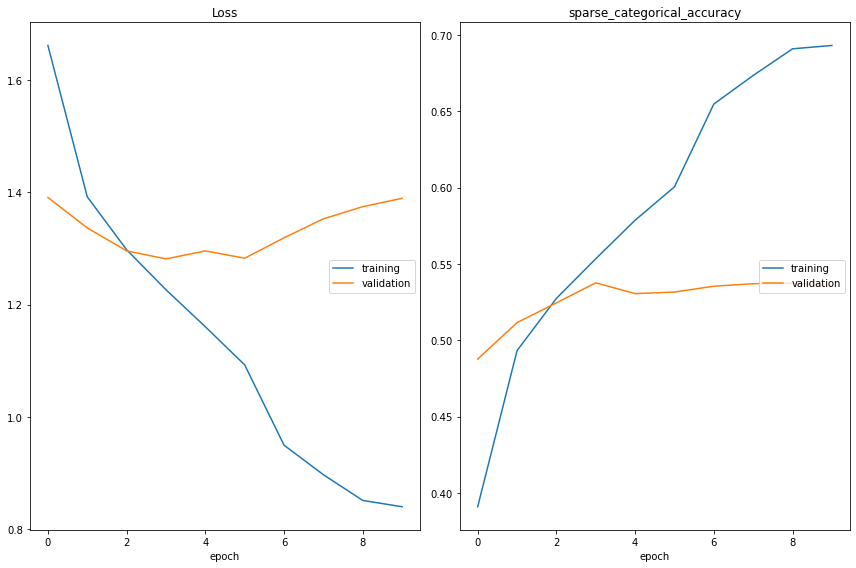

Loss
	training         	 (min:    0.840, max:    1.662, cur:    0.840)
	validation       	 (min:    1.281, max:    1.391, cur:    1.390)
sparse_categorical_accuracy
	training         	 (min:    0.391, max:    0.693, cur:    0.693)
	validation       	 (min:    0.488, max:    0.538, cur:    0.536)

Epoch 00010: val_sparse_categorical_accuracy did not improve from 0.53764


In [24]:
xception_model.fit(train_gen,
                   epochs=15,
                   validation_data=val_gen,
                   callbacks=[PlotLossesCallback(), checkpoint, lr_reducer, early_stopper])

In [28]:
xception_model.save('./saved_model_xception_trial/1')

INFO:tensorflow:Assets written to: ./saved_model_xception_trial/1/assets


In [36]:
xception_model.load_weights("model_xception_trial/checkpoint_best.hdf5")
loss, acc = xception_model.evaluate(val_gen)

309/309 [==============================] - 61s 140ms/step - loss: 1.2600 - sparse_categorical_accuracy: 0.5625


In [35]:
xception_model = tf.keras.models.load_model('./saved_model_xception_trial/1')
xception_model.evaluate(val_gen)

### Определение скорости инференса

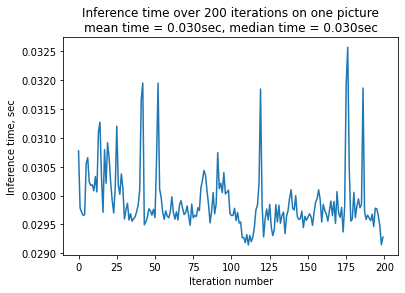

In [58]:
x, _ = next(train_gen)
sample = x[0:1]
benchmark_model(xception_model, sample)

### Предикт на тестовых данных

In [72]:
sample_submission = make_submission(model=xception_model,
                                    preprocessing_function=tf.keras.applications.xception.preprocess_input,
                                    preprocess=True)

100%|██████████| 5000/5000 [04:06<00:00, 20.27it/s]


Сделаем выгрузку в csv для Kaggle

In [73]:
sample_submission.to_csv(data_folder / 'sample_submission_xception.csv', index=False)

In [7]:
xception_submission = pd.read_csv(data_folder / 'sample_submission_xception.csv')

Взглянем на получившиеся данные

In [75]:
sample_submission['image_path'] = sample_submission['image_path'].apply(lambda x: './test_kaggle/' + x)
sample_submission.head()

,image_path,emotion
0,./test_kaggle/0.jpg,sad
1,./test_kaggle/1.jpg,neutral
2,./test_kaggle/10.jpg,neutral
3,./test_kaggle/100.jpg,fear
4,./test_kaggle/1000.jpg,happy


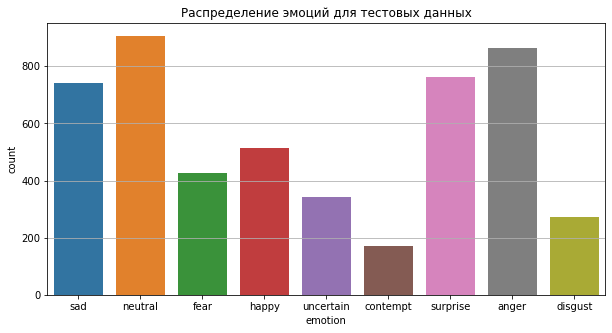

In [76]:
show_emotion_distribution(sample_submission)

### Score on Kaggle

Результаты:
- Private Score: 0.54840
- Public Score: 0.54079

![VGG-full-dataset.png](https://cloud.telecombg.ru/index.php/s/RWmkbZNBiiTomLx/preview)

### Датасет №2

In [20]:
xception_model = tf.keras.applications.xception.Xception(include_top=False,
                                                         weights='imagenet',
                                                         input_tensor=None,
                                                         input_shape=None,
                                                         pooling='avg',
                                                         classes=9,
                                                         classifier_activation='softmax')

xception_model = tf.keras.Sequential([xception_model, tf.keras.layers.Dense(9, activation='softmax')])

In [21]:
train_gen, val_gen = build_generators(dataset='cropped',
                                      train=df_train_cropped,
                                      val=df_val_cropped,
                                      image_size=224,
                                      batch_size=16,
                                      preprocessing_function_train=preprocessing_xception_train,
                                      preprocessing_function_val=tf.keras.applications.xception.preprocess_input)

Found 44440 validated image filenames belonging to 9 classes.
Found 4933 validated image filenames belonging to 9 classes.


In [22]:
xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                       loss='sparse_categorical_crossentropy',
                       metrics=['sparse_categorical_accuracy'])

In [23]:
checkpoint, lr_reducer, early_stopper = build_callbacks(save_path="model_xception_cropped")

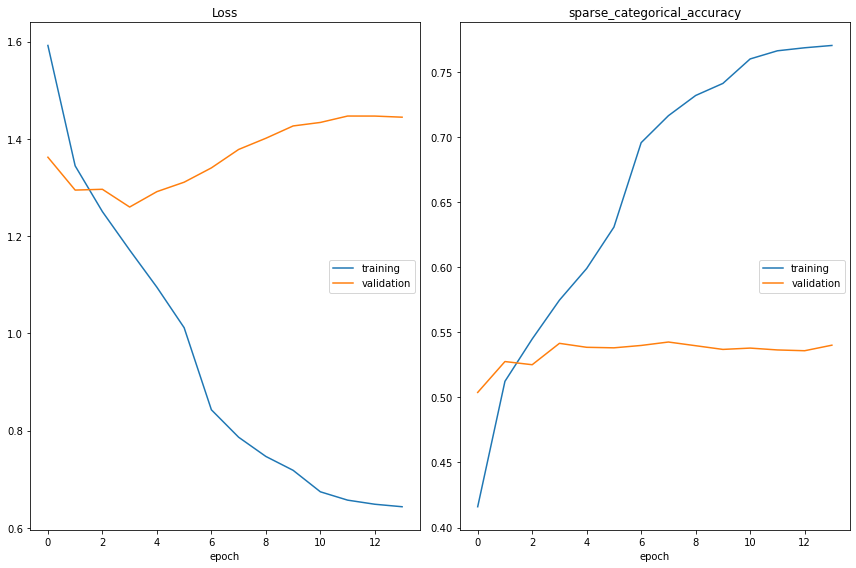

Loss
	training         	 (min:    0.643, max:    1.592, cur:    0.643)
	validation       	 (min:    1.260, max:    1.447, cur:    1.445)
sparse_categorical_accuracy
	training         	 (min:    0.416, max:    0.770, cur:    0.770)
	validation       	 (min:    0.504, max:    0.542, cur:    0.540)

Epoch 00014: val_sparse_categorical_accuracy did not improve from 0.54247


In [24]:
xception_model.fit(train_gen,
                   epochs=15,
                   validation_data=val_gen,
                   callbacks=[PlotLossesCallback(), checkpoint, lr_reducer, early_stopper])

In [27]:
xception_model.save('./saved_model_xception_cropped/1')

INFO:tensorflow:Assets written to: ./saved_model_xception_cropped/1/assets


In [ ]:
xception_model.load_weights("model_xception_cropped/checkpoint_best.hdf5")
loss, acc = xception_model.evaluate(val_gen)

In [ ]:
xception_model = tf.keras.models.load_model('./saved_model_xception_cropped/1')
xception_model.evaluate(val_gen)

### Определение скорости инференса

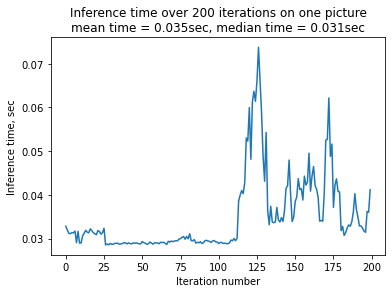

(0.03498093605041504, 0.03132176399230957)

In [25]:
x, _ = next(train_gen)
sample = x[0:1]
benchmark_model(xception_model, sample)

### Предикт на тестовых данных

In [26]:
sample_submission = make_submission(model=xception_model,
                                    preprocessing_function=tf.keras.applications.xception.preprocess_input,
                                    preprocess=True)

100%|██████████| 5000/5000 [04:10<00:00, 19.95it/s]


Сделаем выгрузку в csv для Kaggle

In [28]:
sample_submission.to_csv(data_folder / 'sample_submission_xception_cropped.csv', index=False)

In [48]:
sample_submission = pd.read_csv(data_folder / 'sample_submission_xception_cropped.csv')

Взглянем на получившиеся данные

In [49]:
sample_submission['image_path'] = sample_submission['image_path'].apply(lambda x: './test_kaggle/' + x)
sample_submission.head()

,image_path,emotion
0,./test_kaggle/0.jpg,sad
1,./test_kaggle/1.jpg,neutral
2,./test_kaggle/10.jpg,anger
3,./test_kaggle/100.jpg,sad
4,./test_kaggle/1000.jpg,happy


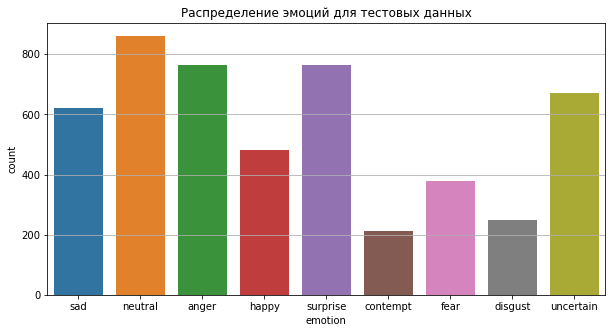

In [50]:
show_emotion_distribution(sample_submission)

### Score on Kaggle

Результаты:
- Private Score: 0.47480
- Public Score: 0.49040

![VGG-full-dataset.png](https://cloud.telecombg.ru/index.php/s/K5JDodCpEwTi7jB/preview)

## BiT

BiT (Big Transfer) сеть, которая создавалась для дообучения под различные задачи. В качастве основы возьмем BiT-M r50x1 модель (архитектура ResNet-50, веса обученны на ImageNet-21k (также известный как "полный ImageNet, релиз осени 2011"). Отличием BiT модели от ResNet является применение стандартизации ядра сверточных слоев, т.е. свертка применяется с ядром (kernel-mean)/var вместо kernel, а так же использованием GroupNormalization (GN) вместо BatchNormalization (BN) при распределенном обучении на ImageNet-21k.

### Датасет №1

In [37]:
bit_model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(224, 224, 3), name='input'),
                                 hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable=True),
                                 tf.keras.layers.Dense(9, activation='softmax', name='output', kernel_initializer='zeros')])

In [38]:
bit_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23500352  
_________________________________________________________________
output (Dense)               (None, 9)                 18441     
Total params: 23,518,793
Trainable params: 23,518,793
Non-trainable params: 0
_________________________________________________________________


In [77]:
train_gen, val_gen = build_generators(dataset='normal',
                                      train=df_train,
                                      val=df_val,
                                      image_size=224,
                                      batch_size=16,
                                      preprocessing_function_train=random_transformation,
                                      preprocessing_function_val=None)

Found 44519 validated image filenames belonging to 9 classes.
Found 4942 validated image filenames belonging to 9 classes.


In [40]:
bit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

In [41]:
checkpoint, lr_reducer, early_stopper = build_callbacks(save_path="model_bit_trial")

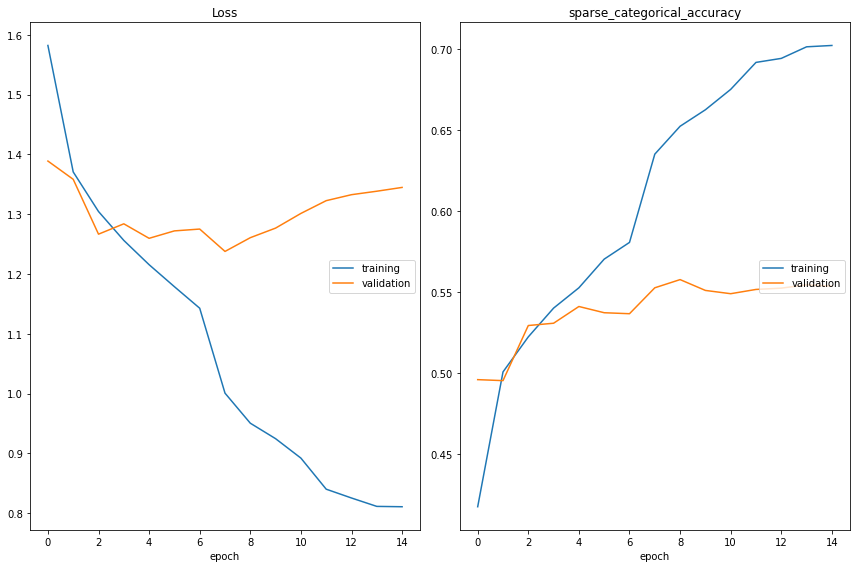

Loss
	training         	 (min:    0.811, max:    1.582, cur:    0.811)
	validation       	 (min:    1.238, max:    1.389, cur:    1.345)
sparse_categorical_accuracy
	training         	 (min:    0.418, max:    0.702, cur:    0.702)
	validation       	 (min:    0.496, max:    0.558, cur:    0.554)

Epoch 00015: val_sparse_categorical_accuracy did not improve from 0.55787


In [23]:
bit_model.fit(train_gen,
              epochs=20,
              validation_data=val_gen,
              callbacks=[PlotLossesCallback(), checkpoint, lr_reducer, early_stopper])

In [32]:
bit_model.save('./saved_model_bit_trial/1')

INFO:tensorflow:Assets written to: ./saved_model_bit_trial/1/assets


INFO:tensorflow:Assets written to: ./saved_model_bit_trial/1/assets


In [43]:
bit_model.load_weights("model_bit_trial/checkpoint_best.hdf5")
loss, acc = bit_model.evaluate(val_gen)

309/309 [==============================] - 75s 168ms/step - loss: 1.2309 - sparse_categorical_accuracy: 0.5793


In [42]:
bit_model = tf.keras.models.load_model('./saved_model_bit_trial/1')
bit_model.evaluate(val_gen)

### Определение скорости инференса

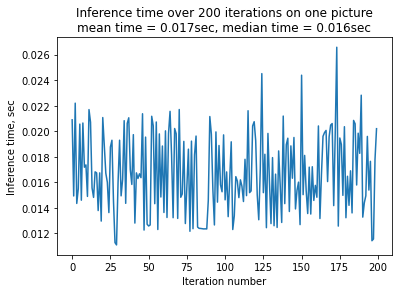

In [61]:
x, _ = next(train_gen)
sample = x[0:1]
_, _, bit_max_time = benchmark_model(bit_model, sample)

### Предикт на тестовых данных

In [78]:
sample_submission = make_submission(model=bit_model,
                                    preprocessing_function=None,
                                    preprocess=False)

100%|██████████| 5000/5000 [04:27<00:00, 18.66it/s]


Сделаем выгрузку в csv для Kaggle

In [79]:
sample_submission.to_csv(data_folder / 'sample_submission_bit.csv', index=False)

In [8]:
bit_submission = pd.read_csv(data_folder / 'sample_submission_bit.csv')

Взглянем на получившиеся данные

In [81]:
sample_submission['image_path'] = sample_submission['image_path'].apply(lambda x: './test_kaggle/' + x)
sample_submission.head()

,image_path,emotion
0,./test_kaggle/0.jpg,sad
1,./test_kaggle/1.jpg,neutral
2,./test_kaggle/10.jpg,neutral
3,./test_kaggle/100.jpg,surprise
4,./test_kaggle/1000.jpg,happy


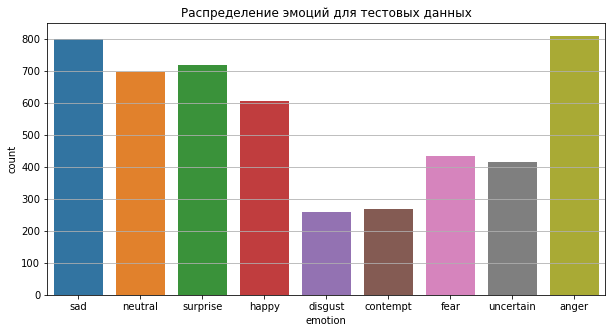

In [82]:
show_emotion_distribution(sample_submission)

### Score on Kaggle

Результаты:
- Private Score: 0.56840
- Public Score: 0.57480

![BIT.png](https://cloud.telecombg.ru/index.php/s/piPEyPwcmFbeeP9/preview)

### Датасет №2

In [33]:
bit_model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(224, 224, 3), name='input'),
                                 hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable=True),
                                 tf.keras.layers.Dense(9, activation='softmax', name='output', kernel_initializer='zeros')])

In [34]:
train_gen, val_gen = build_generators(dataset='cropped',
                                      train=df_train_cropped,
                                      val=df_val_cropped,
                                      image_size=224,
                                      batch_size=16,
                                      preprocessing_function_train=random_transformation,
                                      preprocessing_function_val=None)

Found 44440 validated image filenames belonging to 9 classes.
Found 4933 validated image filenames belonging to 9 classes.


In [35]:
bit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

In [36]:
checkpoint, lr_reducer, early_stopper = build_callbacks(save_path="model_bit_cropped")

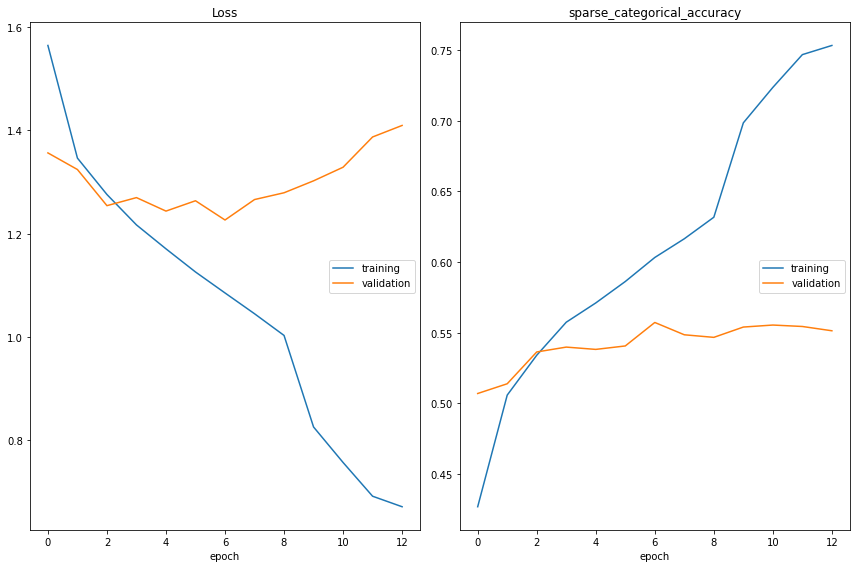

Loss
	training         	 (min:    0.672, max:    1.564, cur:    0.672)
	validation       	 (min:    1.227, max:    1.410, cur:    1.410)
sparse_categorical_accuracy
	training         	 (min:    0.427, max:    0.753, cur:    0.753)
	validation       	 (min:    0.507, max:    0.557, cur:    0.551)

Epoch 00013: val_sparse_categorical_accuracy did not improve from 0.55727


In [37]:
bit_model.fit(train_gen,
              epochs=20,
              validation_data=val_gen,
              callbacks=[PlotLossesCallback(), checkpoint, lr_reducer, early_stopper])

In [ ]:
bit_model.save('./saved_model_bit_cropped/1')

In [ ]:
bit_model.load_weights("model_bit_cropped/checkpoint_best.hdf5")
loss, acc = bit_model.evaluate(val_gen)

In [ ]:
bit_model = tf.keras.models.load_model('./saved_model_bit_cropped/1')
bit_model.evaluate(val_gen)

### Определение скорости инференса

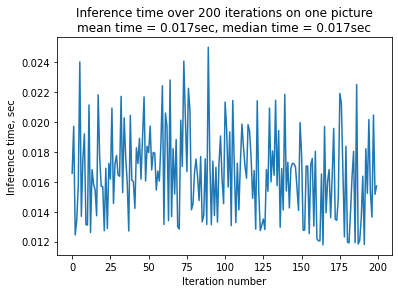

(0.01655626893043518, 0.016543865203857422)

In [38]:
x, _ = next(train_gen)
sample = x[0:1]
benchmark_model(bit_model, sample)

### Предикт на тестовых данных

In [39]:
sample_submission = make_submission(model=bit_model,
                                    preprocessing_function=None,
                                    preprocess=False)

100%|██████████| 5000/5000 [04:40<00:00, 17.82it/s]


Сделаем выгрузку в csv для Kaggle

In [40]:
sample_submission.to_csv(data_folder / 'sample_submission_bit_cropped.csv', index=False)

In [41]:
sample_submission = pd.read_csv(data_folder / 'sample_submission_bit_cropped.csv')

Взглянем на получившиеся данные

In [43]:
sample_submission['image_path'] = sample_submission['image_path'].apply(lambda x: './test_kaggle/' + x)
sample_submission.head()

,image_path,emotion
0,./test_kaggle/./test_kaggle/0.jpg,sad
1,./test_kaggle/./test_kaggle/1.jpg,neutral
2,./test_kaggle/./test_kaggle/10.jpg,neutral
3,./test_kaggle/./test_kaggle/100.jpg,uncertain
4,./test_kaggle/./test_kaggle/1000.jpg,surprise


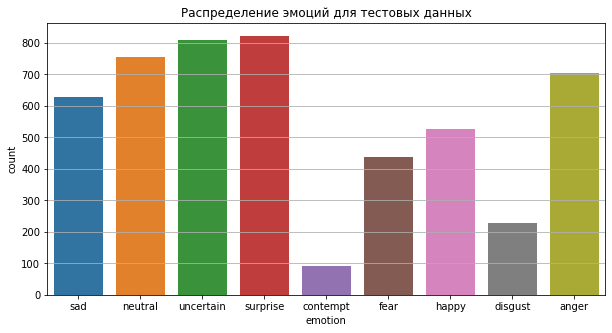

In [44]:
show_emotion_distribution(sample_submission)

### Score on Kaggle

Результаты:
- Private Score: 0.50120
- Public Score: 0.50120

![VGG-full-dataset.png](https://cloud.telecombg.ru/index.php/s/5RbNMqNRkLAmQH7/preview)

## EfficientNetB1

EfficientNet — класс новых моделей, который получился из изучения масштабирования (скейлинг, scaling) моделей и балансирования между собой глубины и ширины (количества каналов) сети, а также разрешения изображений в сети.

### Датасет №1

In [119]:
efficientnetb1_model = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False,
                                                                         weights='imagenet',
                                                                         input_tensor=None,
                                                                         input_shape=(224, 224, 3),
                                                                         pooling='max',
                                                                         classes=9,
                                                                         classifier_activation='softmax')

efficientnetb1_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 224, 224, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 224, 224, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_3[0][0]            
_____________________________________________________________________________________

In [120]:
efficientnetb1_model = tf.keras.Sequential([efficientnetb1_model, tf.keras.layers.Dense(9, activation='softmax')])
efficientnetb1_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 11529     
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________


In [121]:
train_gen, val_gen = build_generators(dataset='normal',
                                      train=df_train,
                                      val=df_val,
                                      image_size=224,
                                      batch_size=16,
                                      preprocessing_function_train=random_transformation,
                                      preprocessing_function_val=None)

Found 44519 validated image filenames belonging to 9 classes.
Found 4942 validated image filenames belonging to 9 classes.


In [122]:
efficientnetb1_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                             loss='sparse_categorical_crossentropy',
                             metrics=['sparse_categorical_accuracy'])

In [123]:
checkpoint, lr_reducer, early_stopper = build_callbacks(save_path="model_efficientnetb1_model")

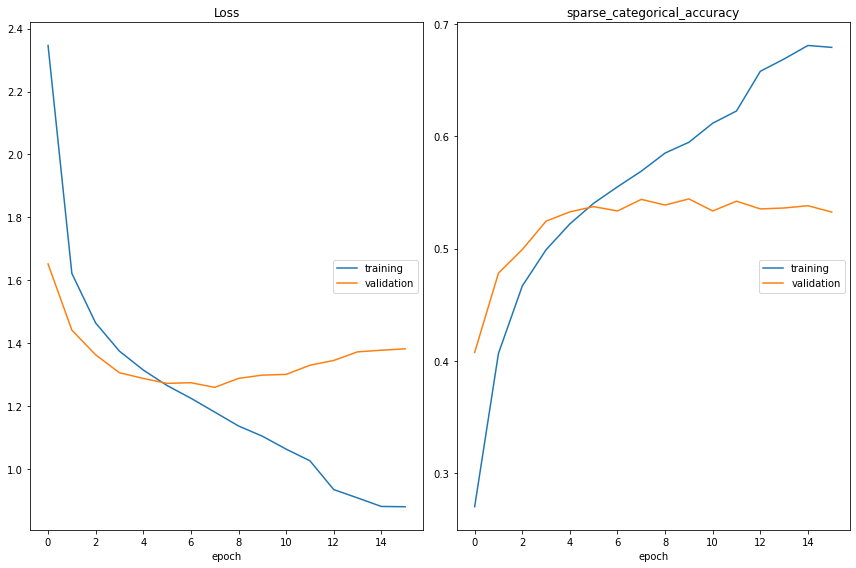

Loss
	training         	 (min:    0.880, max:    2.347, cur:    0.880)
	validation       	 (min:    1.259, max:    1.652, cur:    1.382)
sparse_categorical_accuracy
	training         	 (min:    0.270, max:    0.681, cur:    0.679)
	validation       	 (min:    0.408, max:    0.544, cur:    0.533)

Epoch 00016: val_sparse_categorical_accuracy did not improve from 0.54431


In [25]:
efficientnetb1_model.fit(train_gen,
                         epochs=20,
                         validation_data=val_gen,
                         callbacks=[PlotLossesCallback(), checkpoint, lr_reducer, early_stopper])

In [26]:
efficientnetb1_model.save('./saved_model_efficientnetb1_trial/1')

INFO:tensorflow:Assets written to: ./saved_model_efficientnetb1_trial/1/assets


In [125]:
efficientnetb1_model.load_weights("model_efficientnetb1_model/checkpoint_best.hdf5")
loss, acc = efficientnetb1_model.evaluate(val_gen)

309/309 [==============================] - 28s 84ms/step - loss: 1.3516 - sparse_categorical_accuracy: 0.5494


In [124]:
efficientnetb1_model = tf.keras.models.load_model('./saved_model_efficientnetb1_trial/1')
efficientnetb1_model.evaluate(val_gen)

### Определение скорости инференса

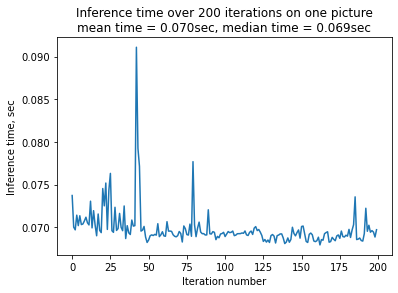

In [51]:
x, _ = next(train_gen)
sample = x[0:1]
benchmark_model(efficientnetb1_model, sample)

### Предикт на тестовых данных

In [126]:
sample_submission = make_submission(model=efficientnetb1_model,
                                    preprocessing_function=None,
                                    preprocess=False)

100%|██████████| 5000/5000 [04:21<00:00, 19.11it/s]


Сделаем выгрузку в csv для Kaggle

In [127]:
sample_submission.to_csv(data_folder / 'sample_submission_efficientnetb1.csv', index=False)

In [9]:
efficientnetb1_submission = pd.read_csv(data_folder / 'sample_submission_efficientnetb1.csv')

Взглянем на получившиеся данные

In [129]:
sample_submission['image_path'] = sample_submission['image_path'].apply(lambda x: './test_kaggle/' + x)
sample_submission.head()

,image_path,emotion
0,./test_kaggle/0.jpg,sad
1,./test_kaggle/1.jpg,neutral
2,./test_kaggle/10.jpg,anger
3,./test_kaggle/100.jpg,neutral
4,./test_kaggle/1000.jpg,happy


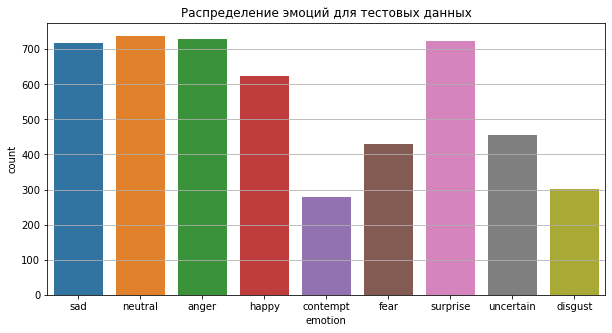

In [130]:
show_emotion_distribution(sample_submission)

### Score on Kaggle

Результаты:
- Private Score: 0.54279
- Public Score: 0.53520

![VGG-full-dataset.png](https://cloud.telecombg.ru/index.php/s/ND438BZSAJ44nzq/preview)

### Датасет №2

In [102]:
efficientnetb1_model = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False,
                                                                         weights='imagenet',
                                                                         input_tensor=None,
                                                                         input_shape=(224, 224, 3),
                                                                         pooling='max',
                                                                         classes=9,
                                                                         classifier_activation='softmax')

efficientnetb1_model = tf.keras.Sequential([efficientnetb1_model, tf.keras.layers.Dense(9, activation='softmax')])

In [103]:
train_gen, val_gen = build_generators(dataset='cropped',
                                      train=df_train_cropped,
                                      val=df_val_cropped,
                                      image_size=224,
                                      batch_size=16,
                                      preprocessing_function_train=random_transformation,
                                      preprocessing_function_val=None)

Found 44440 validated image filenames belonging to 9 classes.
Found 4933 validated image filenames belonging to 9 classes.


In [104]:
efficientnetb1_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                             loss='sparse_categorical_crossentropy',
                             metrics=['sparse_categorical_accuracy'])

In [105]:
checkpoint, lr_reducer, early_stopper = build_callbacks(save_path="model_efficientnetb1_model_cropped")

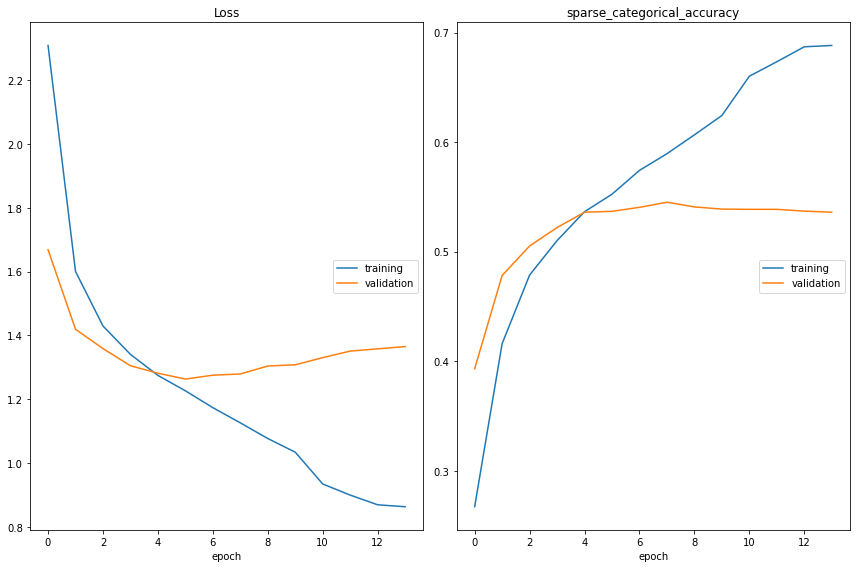

Loss
	training         	 (min:    0.863, max:    2.308, cur:    0.863)
	validation       	 (min:    1.263, max:    1.668, cur:    1.365)
sparse_categorical_accuracy
	training         	 (min:    0.267, max:    0.688, cur:    0.688)
	validation       	 (min:    0.393, max:    0.545, cur:    0.536)

Epoch 00014: val_sparse_categorical_accuracy did not improve from 0.54510


In [205]:
efficientnetb1_model.fit(train_gen,
                         epochs=20,
                         validation_data=val_gen,
                         callbacks=[PlotLossesCallback(), checkpoint, lr_reducer, early_stopper])

In [212]:
efficientnetb1_model.save('./saved_model_efficientnetb1_cropped/1')

INFO:tensorflow:Assets written to: ./saved_model_efficientnetb1_cropped/1/assets


In [ ]:
efficientnetb1_model = tf.keras.models.load_model('./saved_model_efficientnetb1_cropped/1')
efficientnetb1_model.evaluate(val_gen)

### Определение скорости инференса

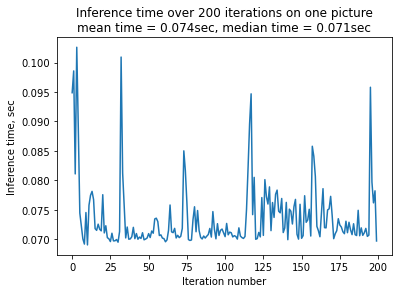

(0.07364348888397217, 0.07147085666656494)

In [206]:
x, _ = next(train_gen)
sample = x[0:1]
benchmark_model(efficientnetb1_model, sample)

### Предикт на тестовых данных

In [207]:
sample_submission = make_submission(model=efficientnetb1_model,
                                    preprocessing_function=None,
                                    preprocess=False)

100%|██████████| 5000/5000 [04:33<00:00, 18.31it/s]


Сделаем выгрузку в csv для Kaggle

In [208]:
sample_submission.to_csv(data_folder / 'sample_submission_efficientnetb1_cropped.csv', index=False)

In [209]:
sample_submission = pd.read_csv(data_folder / 'sample_submission_efficientnetb1_cropped.csv')

Взглянем на получившиеся данные

In [210]:
sample_submission['image_path'] = sample_submission['image_path'].apply(lambda x: './test_kaggle/' + x)
sample_submission.head()

,image_path,emotion
0,./test_kaggle/0.jpg,sad
1,./test_kaggle/1.jpg,neutral
2,./test_kaggle/10.jpg,neutral
3,./test_kaggle/100.jpg,fear
4,./test_kaggle/1000.jpg,happy


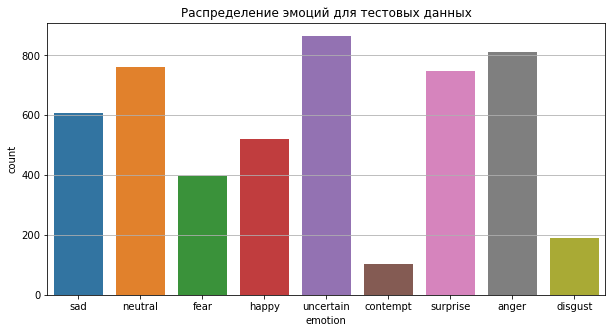

In [211]:
show_emotion_distribution(sample_submission)

### Score on Kaggle

Результаты:
- Private Score: 0.47000
- Public Score: 0.47960

![E-cropp-dataset.png](https://cloud.telecombg.ru/index.php/s/wd77C4xzzwpd9YH/preview)

## Выводы

В целом, все модели обученные на датасете с вырезанными лицами показали меньшую точность на тестовых данных чем модели, обученные на не обрезанном датасете. Вероятно это связано с ограниченными возможностями для аугментаций и возможной потере информации при обрезке.

## Комитет

Объединим информацию о предсказаниях всех четырёх моделей на тестовых данных для датасета №1. Создадим так называемый комитет, в котором будет выбираться наиболее часто встречающееся предсказание для каждого тестового изображения. Если все предсказания отличаются друг от друга, то выбирается решение первой модели в списке, в данном случае - VGG.

In [16]:
committee = pd.DataFrame()

committee['image_path'] = bit_submission['image_path'].copy()
committee['vgg'] = vgg_submission['emotion'].copy()
committee['xception'] = xception_submission['emotion'].copy()
committee['bit'] = bit_submission['emotion'].copy()
committee['efficientnet'] = efficientnetb1_submission['emotion'].copy()

committee['total'] = committee['vgg'].apply(lambda x: [x]) + committee['xception'].apply(lambda x: [x]) + committee['bit'].apply(lambda x: [x]) + committee['efficientnet'].apply(lambda x: [x])

committee['emotion'] = committee['total'].apply(lambda x: mode(x))

committee[['image_path', 'emotion']].to_csv(data_folder / 'send.csv', index=False)

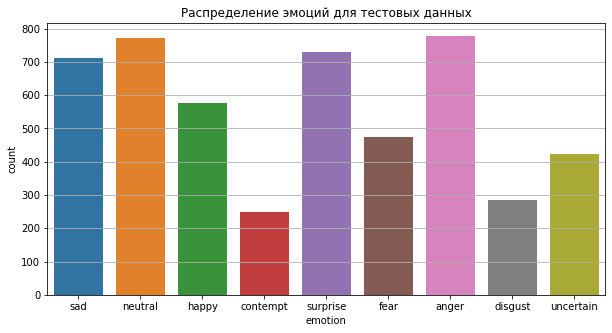

In [100]:
show_emotion_distribution(committee[['image_path', 'emotion']])

### Определение скорости суммарного инференса

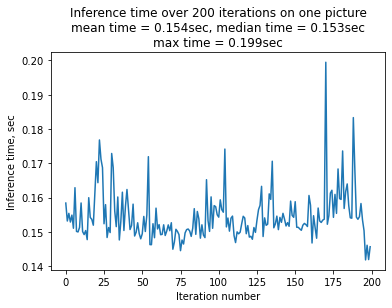

In [133]:
x, _ = next(train_gen)
sample = x[0:1]
iterations = 200

vggface_model(sample)
xception_model(sample)
bit_model(sample)
efficientnetb1_model(sample)  

inference_times = []

for i in range(iterations):
    start = time.time()
    vggface_model(sample)
    xception_model(sample)
    bit_model(sample)
    efficientnetb1_model(sample)
    inference_times.append(time.time() - start)

mean_time = np.mean(inference_times)
median_time = np.median(inference_times)
max_time = np.amax(inference_times)

plt.plot(inference_times)
plt.title(f'Inference time over {iterations} iterations on one picture\n'
          f'mean time = {mean_time:.3f}sec, median time = {median_time:.3f}sec\n'
          f'max time = {max_time:.3f}sec')
plt.xlabel('Iteration number')
plt.ylabel('Inference time, sec')
plt.show()

Суммарное максимальное время инференса четырёх моделей не превышает предельно допустимый порог в 0.33 секунды (3 кадра в секунду).

### Score on Kaggle

Решение с комитетом позволило значительно увеличить score на Kaggle по сравнению с одиночными моделями до 0.58399 на Public и до 0.58600 на Private

![Bagging.png](https://cloud.telecombg.ru/index.php/s/iWwSCmJsKcbZ4bo/preview)